In [2]:
!pip install -Uqq fastai
!pip install -qq duckduckgo_search

In [3]:
#Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastcore.all import *
from duckduckgo_search import ddg_images

In [4]:
#Def search function
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    #L is a fastAI function that converts a list into a fastAI list
    return L(ddg_images(term, max_results=max_images)).itemgot('image')
    #Alternatively, you can use the following code (much easier to read...)
    return [result['image'] for result in search_results]


In [5]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('elon musk', max_images=1)
urls[0]

Searching for 'elon musk'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'https://media.vanityfair.com/photos/609d51288fee0e2d204a86ea/master/w_2560%2Cc_limit/Elon5.13.jpg'

In [6]:
urls

(#1) ['https://media.vanityfair.com/photos/609d51288fee0e2d204a86ea/master/w_2560%2Cc_limit/Elon5.13.jpg']

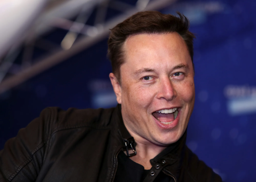

In [7]:
from fastdownload import download_url
dest = 'elon.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'jackie chan'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


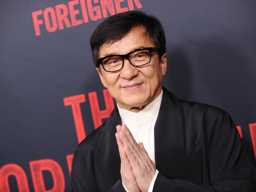

In [8]:
download_url(search_images('jackie chan', max_images=1)[0], 'jackie.jpg', show_progress=False)
Image.open('jackie.jpg').to_thumb(256,256)

In [9]:
searches = 'jackie chan','elon musk'
path = Path('elon_or_jackie')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    #Per default earch images set to 30 pictures
    download_images(dest, urls=search_images(f'{o} face'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun face'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade face'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'jackie chan face'
Searching for 'jackie chan sun face'
Searching for 'jackie chan shade face'
Searching for 'elon musk face'
Searching for 'elon musk sun face'
Searching for 'elon musk shade face'


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

18

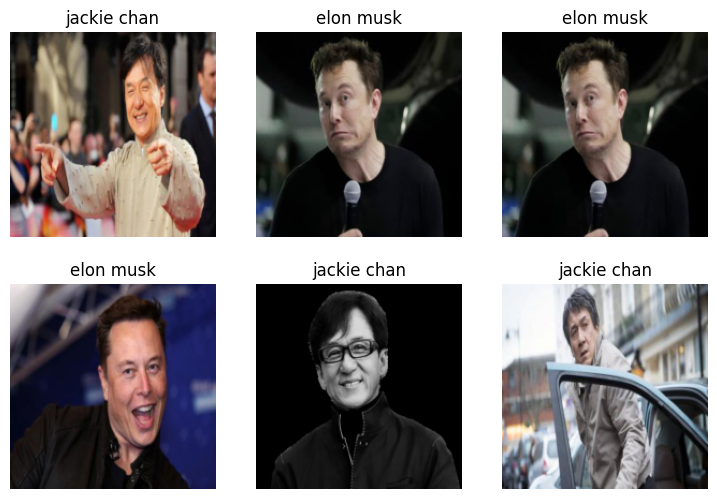

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)
#Took 12 sec to run on remote GPU, paperspace
#Took 13 sec to run on remote GPU Colab (T4, free)
#Took 58 sec on local CPU

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.187094,0.503565,0.241379,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.321397,0.462585,0.275862,00:01
1,0.237708,0.274790,0.172414,00:01
2,0.182313,0.222129,0.137931,00:01
3,0.139101,0.160615,0.068965,00:01
4,0.111960,0.154071,0.068965,00:01


In [13]:
is_elon,_,probs = learn.predict(PILImage.create('elon.jpg'))
print(f"This is : {is_elon}.")
print(f"Probability it's Elon is: {probs[0]:.4f}")

This is : elon musk.
Probability it's Elon is: 0.9999
